<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_modelo_futuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Modelo futuro

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os, random

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Lambda
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEMENTE = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'
CORES  = ['#007F66', '#339966', '#66B266', '#99CC66', '#CCE566']

LINHA_ESPESSURA = 1

LOTE_TAMANHO = 32

CAMADAS = 4

CAMADA_UNIDADES      = 64
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

# SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'linear'

PERDA       = 'mae'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['mae', 'mse']

ITERACOES = 500

## Funções

In [3]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py

--2023-03-09 18:13:36--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7189 (7.0K) [text/plain]
Saving to: ‘PJI410_funcoes_auxiliares.py’

PJI410_funcoes_auxi 100%[===================>]   7.02K  --.-KB/s    in 0s      

2023-03-09 18:13:36 (36.8 MB/s) - ‘PJI410_funcoes_auxiliares.py’ saved [7189/7189]



In [4]:
from PJI410_funcoes_auxiliares import criar_janelas, gerar_previsoes_futuro, grafico_series, set_global_determinism

# Dados

In [5]:
df_populacao  = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_populacao.csv')
df_municipios = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_municipios.csv')
df_unidades   = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_unidades.csv')

df_notificacoes_por_unidade = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_notificacoes_por_unidade.zip', parse_dates=['Segunda-feira'])
df_notificacoes_por_unidade = df_notificacoes_por_unidade[['UF', 'Municipio', 'Unidade', 'Segunda-feira', 'Quantidade']]
df_notificacoes_por_unidade = df_notificacoes_por_unidade.sort_values(by=['UF', 'Municipio', 'Unidade', 'Segunda-feira']).reset_index(drop=True)

df_notificacoes_por_municipio = df_notificacoes_por_unidade[['UF', 'Municipio', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Municipio', 'Segunda-feira']).sum()
df_notificacoes_por_municipio = df_notificacoes_por_municipio.sort_index().reset_index()

df_notificacoes_por_uf = df_notificacoes_por_unidade[['UF', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Segunda-feira']).sum()
df_notificacoes_por_uf = df_notificacoes_por_uf.sort_index().reset_index()

df_notificacoes_por_semana = df_notificacoes_por_unidade[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).sum()
df_notificacoes_por_semana = df_notificacoes_por_semana.sort_index().reset_index()

In [6]:
dados = df_notificacoes_por_semana
q_treino = int(len(dados) * 0.8)

quantidades = dados['Quantidade'].to_numpy().astype('float32')

In [7]:
X_train = dados[:q_treino]['Segunda-feira'].to_numpy()
y_train = dados[:q_treino]['Quantidade'].to_numpy()

X_test = dados[q_treino:]['Segunda-feira'].to_numpy()
y_test = dados[q_treino:]['Quantidade'].to_numpy()

# Modelo

In [8]:
janela_tamanho = 7
horizonte_tamanho = 1
quantidade_intervalos = 8

# quantidades = df_notificacoes_por_uf[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).mean()
# quantidades = quantidades.sort_index().reset_index()['Quantidade'].to_numpy().astype('float32')

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

dataset_janelas    = Dataset.from_tensor_slices(janelas)
dataset_horizontes = Dataset.from_tensor_slices(horizontes)

dataset_completo = Dataset.zip((dataset_janelas, dataset_horizontes))
dataset_completo = dataset_completo.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

In [9]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_futuro'

modelo_futuro = Sequential(name=modelo_nome)

modelo_futuro.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))

modelo_futuro.add(Conv1D(filters=CAMADA_UNIDADES,
                         kernel_size=janela_tamanho,
                         kernel_initializer=CAMADA_INICIALIZADOR,
                         padding='causal',
                         activation=CAMADA_ATIVACAO,
                         name='camada_convulacional'))

modelo_futuro.add(Dense(units=CAMADA_UNIDADES, activation=CAMADA_ATIVACAO, name='camada_densa'))

modelo_futuro.add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelo_futuro.compile(loss=PERDA,
                      optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                      metrics=METRICAS)

modelo_futuro.fit(dataset_completo, epochs=ITERACOES, verbose=0)

CPU times: user 10.2 s, sys: 451 ms, total: 10.7 s
Wall time: 20.4 s


In [10]:
# previsoes = gerar_previsoes_futuro(modelo_futuro, quantidades, quantidade_intervalos, janela_tamanho)

# df_futuro = pd.DataFrame(pd.date_range(X_test.max(), periods=(quantidade_intervalos + 1), freq='W-MON', closed='right').to_numpy(), columns=['Segunda-feira'])
# df_futuro['Quantidade'] = previsoes

# display(df_futuro)

# grafico_series(X_previsao=df_futuro['Segunda-feira'], y_previsao=df_futuro['Quantidade'])

## Testes

In [11]:
# uf_cod  = 'MG'
# uf_desc = df_populacao['Nome'][df_populacao['UF'] == uf_cod].values[0]

# dados = df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod]
# local = f"{uf_cod} - {uf_desc}"

In [16]:
lo = random.randint(0, 2)
dados = []
local = ''

while(len(dados) <= 16):
    if(lo == 0):
        uf_cod, uf_desc = df_populacao[['UF', 'Nome']].sample().values[0]
        dados = df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod]
        local = f" {uf_cod} - {uf_desc}"
    elif(lo == 1):
        mu_cod, mu_desc = df_municipios[['Codigo', 'Municipio']].sample().values[0]
        dados = df_notificacoes_por_municipio[df_notificacoes_por_municipio['Municipio'] == mu_cod]

        if len(dados) > 0:
            local = f"\n{mu_cod} - {mu_desc} ({dados['UF'].values[0]})"
    else:
        un_cod, un_desc = df_unidades[['Codigo', 'Unidade']].sample().values[0]
        dados = df_notificacoes_por_unidade[df_notificacoes_por_unidade['Unidade'] == un_cod]

        if len(dados) > 0:
            mu_cod, mu_desc = df_municipios[['Codigo', 'Municipio']][df_municipios['Codigo'] == dados['Municipio'].values[0]].values[0]
            local = f"\n{mu_cod} - {mu_desc} ({dados['UF'].values[0]})\nUnidade {un_cod} - {un_desc}"

In [17]:
X_train = dados[:-quantidade_intervalos]['Segunda-feira'].to_numpy()
y_train = dados[:-quantidade_intervalos]['Quantidade'].to_numpy()

X_test = dados[-quantidade_intervalos:]['Segunda-feira'].to_numpy()
y_test = dados[-quantidade_intervalos:]['Quantidade'].to_numpy()

y_pred = gerar_previsoes_futuro(modelo_futuro, y_train, quantidade_intervalos, janela_tamanho)

# Inclui o último valor de treino no teste e na previsão, para o gráfico não parecer quebrado.
X_test = np.insert(X_test, 0, X_train[-1])
y_test = np.insert(y_test, 0, y_train[-1])
y_pred = np.insert(y_pred, 0, y_train[-1])

In [18]:
# modelo_futuro, y_train, quantidade_intervalos, janela_tamanho, dados

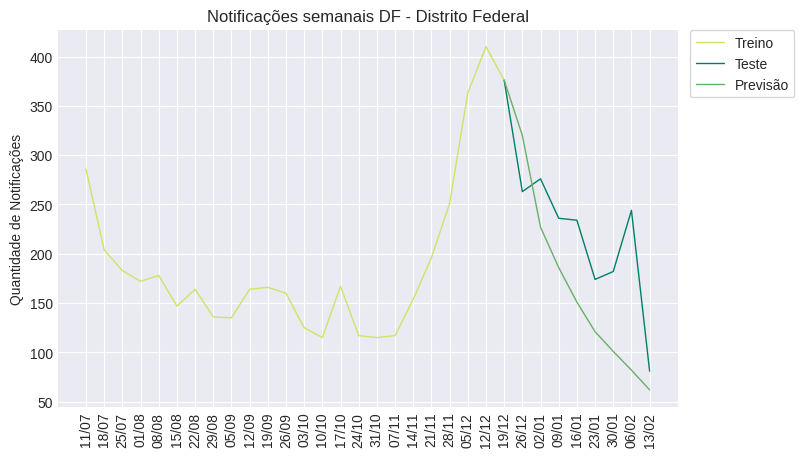

In [19]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test,
               X_previsao=X_test, y_previsao=y_pred,
               inicio=-24, local=local)